## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
from random import sample

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
78548,00019271_031.png,Atelectasis,31,19271,54,M,AP,3056,2544,0.139,0.139,NaN,/data/images_009/images/00019271_031.png
103428,00027592_015.png,Emphysema,15,27592,63,M,PA,2992,2991,0.143,0.143,NaN,/data/images_011/images/00027592_015.png
35497,00009361_001.png,No Finding,1,9361,53,M,PA,2500,2048,0.168,0.168,NaN,/data/images_005/images/00009361_001.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
106795,00028819_000.png,Cardiomegaly|Mass,0,28819,47,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
82980,00020404_000.png,Atelectasis|Fibrosis|Pleural_Thickening,0,20404,67,M,PA,2566,2804,0.143000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10338,00002676_000.png,No Finding,0,2676,45,F,PA,2048,2500,0.171000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class']=all_xray_df['Pneumonia']
all_xray_df['pneumonia_class'].replace([0,1],['Not Pneumonia','Pneumonia'],inplace=True)

## Create your training and testing data:

In [5]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = train_test_split(df, test_size = 0.2, stratify = df['pneumonia_class'])
    
    
    # To have equal amount of positive and negative cases of Pneumonia in training set
    p_inds = train_data[train_data.Pneumonia==1].index.tolist()
    np_inds = train_data[train_data.Pneumonia==0].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]
    
    
    # Change the positive cases in validation set to 20%. Original dataset is about 1.3%
    # Assume the prevalence of Pneumonia is 20% when the patients have clinical symptoms 
    p_inds = val_data[val_data.Pneumonia==1].index.tolist()
    np_inds = val_data[val_data.Pneumonia==0].index.tolist()

    np_sample = sample(np_inds,4*len(p_inds))
    val_data = val_data.loc[p_inds + np_sample]
    
    
    return train_data, val_data

In [6]:
train_data, val_data=create_splits(all_xray_df)

In [7]:
print('Number of samples in training set:',len(train_data))
print('Number of samples in validation set:',len(val_data))

Number of samples in training set: 2290
Number of samples in validation set: 1430


In [18]:
# Checking information of training set
min_age = np.min(train_data['Patient Age'])
max_age = np.max(train_data['Patient Age'][train_data['Patient Age']<100])
male = (train_data['Patient Gender']=='M').sum()
female = len(train_data) - male
print('The age of patients in training set is from {} to {}.'.format(min_age, max_age))
print('There are {} male aand {} female.'.format(male, female))

The age of patients in training set is from 2 to 90.
There are 1324 male aand 966 female.


In [17]:
# Checking information of validation set
min_age = np.min(val_data['Patient Age'])
max_age = np.max(val_data['Patient Age'][val_data['Patient Age']<100])
male = (val_data['Patient Gender']=='M').sum()
female = len(val_data) - male
print('The age of patients in validation set is from {} to {}.'.format(min_age, max_age))
print('There are {} male aand {} female.'.format(male, female))

The age of patients in validation set is from 2 to 92.
There are 802 male aand 628 female.


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [8]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

    return my_idg


def make_train_gen(train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
    # Todo
    my_idg = my_image_augmentation()
    train_gen = my_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 32
                                         )
        
    return train_gen


def make_val_gen(val_df):

    # Todo
    # Just rescale intensity in validation set
    val_idg = ImageDataGenerator(rescale=1. / 255.0)

    val_gen = val_idg.flow_from_dataframe(dataframe=val_df,
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 1430
                                         )
        
    return val_gen


In [9]:
IMG_SIZE = (224, 224)
train_gen = make_train_gen(train_data)
val_gen = make_val_gen(val_data)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [10]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

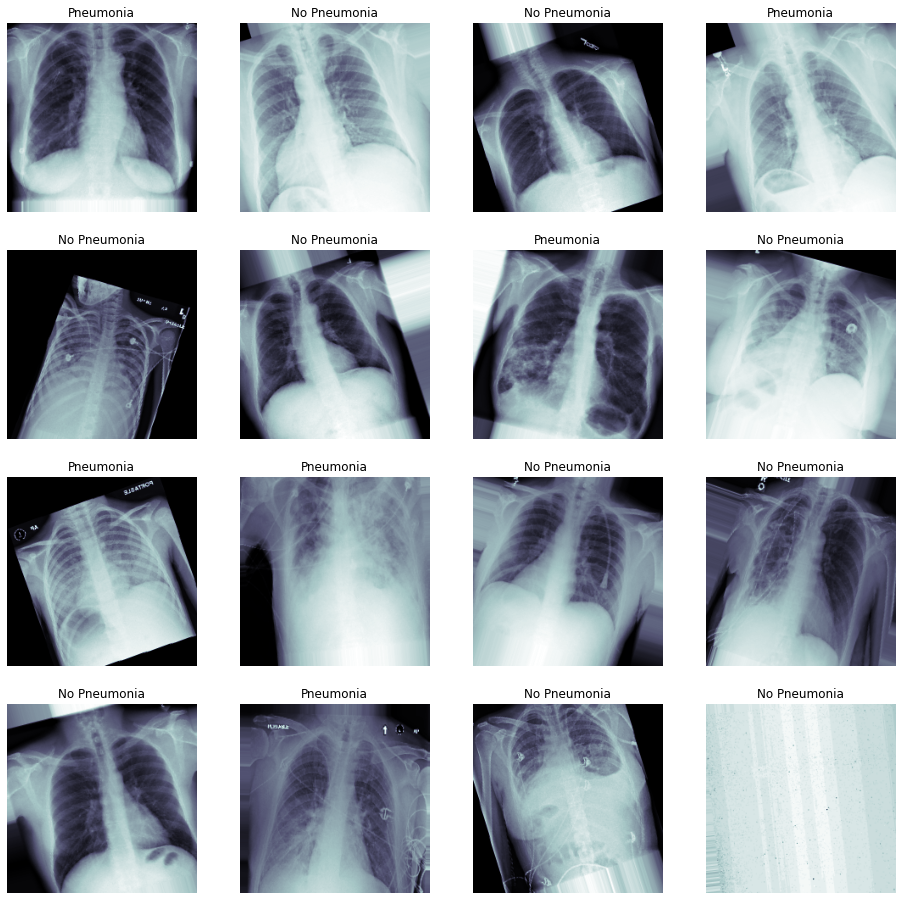

In [11]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [12]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    return vgg_model


In [13]:
vgg_model = load_pretrained_model()

553467904/553467096 [==============================] - 5s 0us/step


In [14]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [15]:
def build_my_model(vgg_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo

    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
        
    my_model = Sequential()
    my_model.add(vgg_model)
    my_model.add(Flatten())
    my_model.add(Dropout(0.2))
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.2))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.2))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dense(1, activation='sigmoid'))
    
    my_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [16]:
my_model = build_my_model(vgg_model)

In [17]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [18]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [19]:
## train your model

# Todo

history = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY),
                           epochs = 100, 
                           callbacks = callbacks_list)

Epoch 1/100
72/72 [==============================] - 80s 1s/step - loss: 0.7270 - binary_accuracy: 0.5301 - val_loss: 0.6641 - val_binary_accuracy: 0.6287

Epoch 00001: val_loss improved from inf to 0.66412, saving model to xray_class_my_model.best.hdf5
Epoch 2/100
72/72 [==============================] - 63s 873ms/step - loss: 0.6810 - binary_accuracy: 0.5747 - val_loss: 0.6101 - val_binary_accuracy: 0.6497

Epoch 00002: val_loss improved from 0.66412 to 0.61006, saving model to xray_class_my_model.best.hdf5
Epoch 3/100
72/72 [==============================] - 63s 878ms/step - loss: 0.6764 - binary_accuracy: 0.5913 - val_loss: 0.5574 - val_binary_accuracy: 0.7657

Epoch 00003: val_loss improved from 0.61006 to 0.55742, saving model to xray_class_my_model.best.hdf5
Epoch 4/100
72/72 [==============================] - 62s 866ms/step - loss: 0.6673 - binary_accuracy: 0.5939 - val_loss: 0.5815 - val_binary_accuracy: 0.7063

Epoch 00004: val_loss did not improve from 0.55742
Epoch 5/100
72

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [20]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, verbose = True)

1430/1430 [==============================] - 12s 8ms/step


In [21]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')


## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')


# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    N = len(history.history["loss"])
    plt.figure()
    fig, (ax1,ax2) = plt.subplots(1, 2,figsize = (10, 10))
    plt.ylim([0, 1])

    ax1.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    ax1.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")

    ax2.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    ax2.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")

    ax1.set(xlabel="Epoch #",ylabel="Loss", title = "Training Loss on Dataset")
    ax2.set(xlabel="Epoch #",ylabel="Accuracy", title = "Accuracy on Dataset")
    ax1.legend(loc="lower left")
    ax2.legend(loc="lower left")

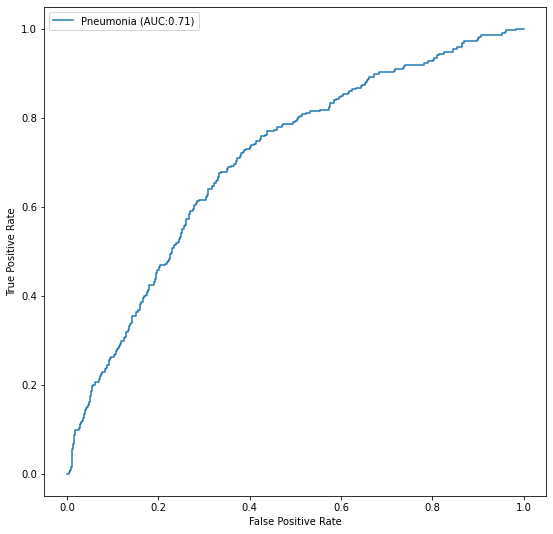

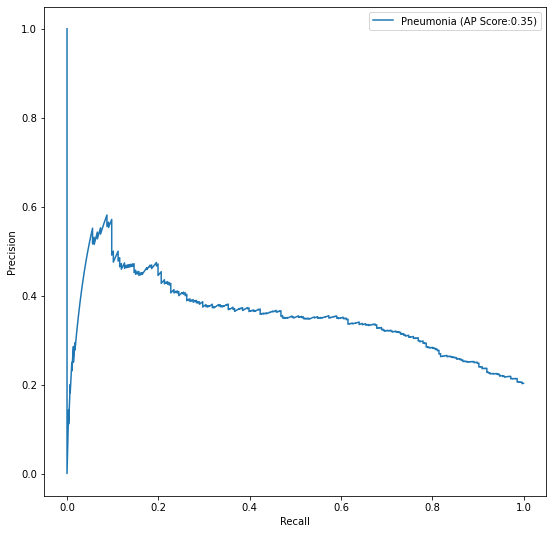

<Figure size 432x288 with 0 Axes>

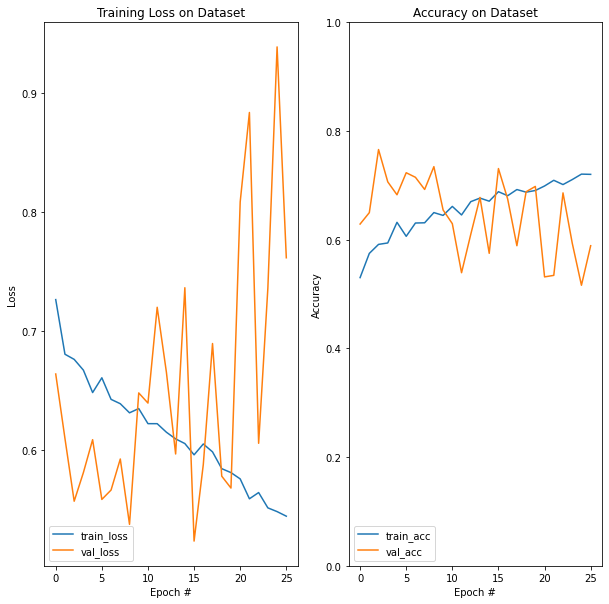

In [22]:
## plot figures

# Todo
plot_auc(valY,pred_Y)
plot_precision_recall_curve(valY,pred_Y)
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [23]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
# 
def predict(threshold, pred_Y):
    p_y = np.zeros(len(pred_Y))
    p_y[pred_Y.flatten()>threshold]=1
    return p_y

# Function to calculate metric
def metric(t_y, p_y):
    tn, fp, fn, tp = confusion_matrix(t_y,p_y).ravel()
    
    # Accuracy
    acc = (tp + tn) / len(t_y)
    
    # Precision, recall and specificity
    prec = tp/(tp+fp)
    rec = tp/(tp+fn)
    spec = tn/(tn+fp)
    
    # F1 score
    f1 = 2*(prec*rec)/(prec+rec)
    return acc, prec, rec, spec, f1


In [24]:
# Add the prediction into the dataframe
val_data['Prediction']= pred_Y

In [25]:
thres_list=[i/100 for i in range(80)]
acc_list=[]
prec_list=[]
rec_list=[]
spec_list=[]
f1_list=[]

for threshold in thres_list:
    p_y = predict(threshold,pred_Y)
    acc, prec, rec, spec, f1 = metric(valY, p_y)
    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    spec_list.append(spec)
    f1_list.append(f1)


Text(0, 0.5, 'F1 score')

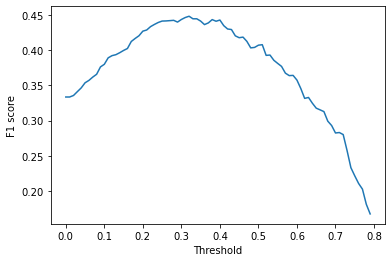

In [26]:
plt.plot(thres_list, f1_list)
plt.xlabel('Threshold')
plt.ylabel('F1 score')

Text(0, 0.5, 'Accuracy')

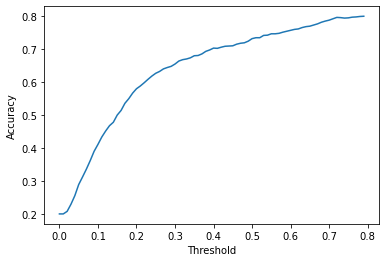

In [27]:
plt.plot(thres_list, acc_list)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

In [28]:
my_threshold = thres_list[np.argmax(f1_list)]
best_f1 = np.max(f1_list)
my_prec = prec_list[np.argmax(f1_list)]
my_rec = rec_list[np.argmax(f1_list)]
my_spec = spec_list[np.argmax(f1_list)]
my_acc = acc_list[np.argmax(f1_list)]
print('The optimal threshold : {}'.format(my_threshold))
print('F1 score : {:.4f}'.format(best_f1))
print('Precision : {:.4f}'.format(my_prec))
print('Recall : {:.4f}'.format(my_rec))
print('Specificity : {:.4f}'.format(my_spec))
print('Accurary : {:.4f}'.format(my_acc))

The optimal threshold : 0.32
F1 score : 0.4478
Precision : 0.3351
Recall : 0.6748
Specificity : 0.6652
Accurary : 0.6671


In [29]:
# Check the limiiation of model
all_labels.remove('No Finding')
all_labels.remove('Pneumonia')

In [30]:
val_data.Prediction=val_data.Prediction>my_threshold
val_data.Prediction.replace([True, False],[1,0], inplace = True)

In [31]:
for i in all_labels:

    tn, fp, fn, tp = confusion_matrix(val_data[val_data[i]==1].Pneumonia.values,
                                                  val_data[val_data[i]==1].Prediction.values,labels=[0,1]).ravel()
    rec = tp/(tp+fn)
    spec = tn/(tn+fp)

    print(i)
    print('Recall: {:.4f}'.format(rec))
    print('Specificity: {:.4f}'.format(spec))
    print()


Atelectasis
Recall: 0.4583
Specificity: 0.5510

Cardiomegaly
Recall: 0.5714
Specificity: 0.7143

Consolidation
Recall: 0.4286
Specificity: 0.5385

Edema
Recall: 0.2877
Specificity: 0.6875

Effusion
Recall: 0.2982
Specificity: 0.5274

Emphysema
Recall: 0.0000
Specificity: 0.8095

Fibrosis
Recall: 0.2500
Specificity: 0.7500

Hernia
Recall: nan
Specificity: 0.5000

Infiltration
Recall: 0.3103
Specificity: 0.5825

Mass
Recall: 0.2500
Specificity: 0.6111

Nodule
Recall: 0.3846
Specificity: 0.6774

Pleural_Thickening
Recall: 0.5000
Specificity: 0.4524

Pneumothorax
Recall: 0.5000
Specificity: 0.6316



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


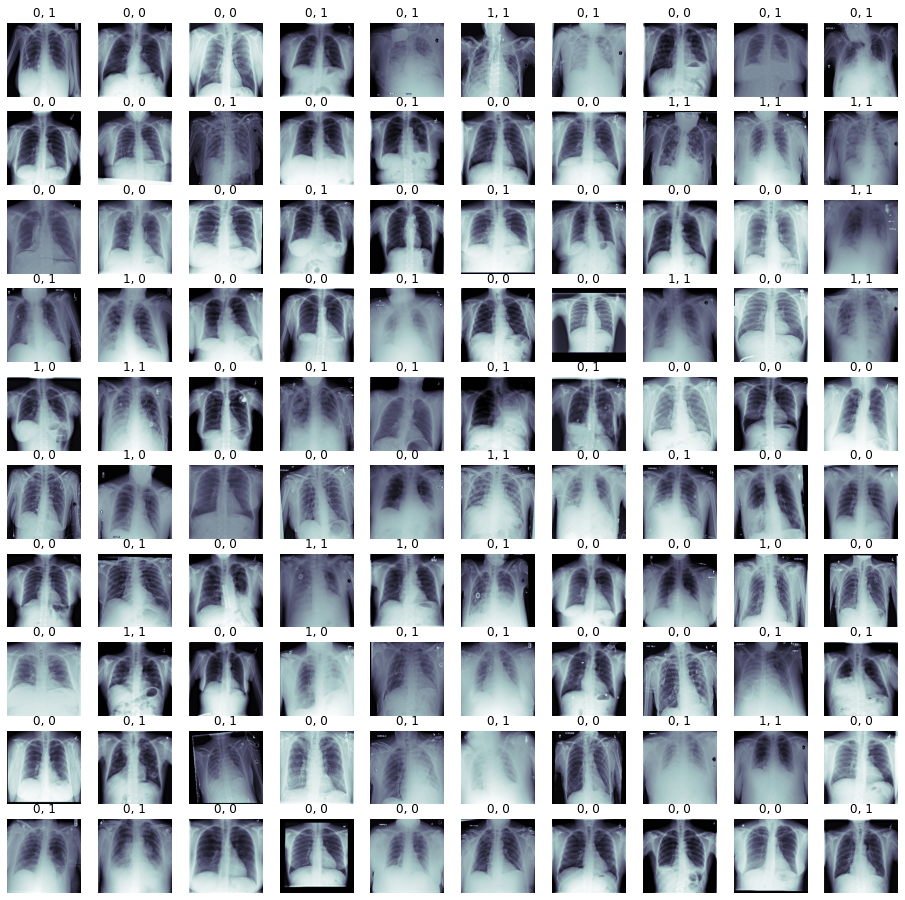

In [32]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > my_threshold:
             c_ax.set_title('1, 1')
        else:
             c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > my_threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [33]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)